In [1]:
import os
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
import zipfile
from torchvision import transforms
from skimage.measure import compare_ssim as ssim

## Data exploration

This is a simple exploration of data structure and submission format.

First of all, run downloader.py. It will create folder 'data' and download competition data and lists. Then unzip imgs.zip to data/imgs/ folder

In [2]:
df = pd.read_csv('data/pairs_list.csv')
df.head()

,source_imgs,target_imgs
0,60f5fb295648e54bd1dc0c859c8fff620ee2eb40.jpg|b...,48f9c10f6e20153d752bbb7248016df80a16f4c3.jpg|2...
1,3e15d19b62ba5c991e8a0d9f85ddb3d8adde9a31.jpg|9...,d53757cc366571251a74d4df211b05b67a279eb2.jpg|d...
2,2cf2e394b1a4fa1d4f71a11deb5eaccfd757d668.jpg|2...,8f9faa1124481d2749ca5ec90c8762fb69a244b7.jpg|b...
3,dcf724dec8125b19bbdc5ab328f3affcdd124a3a.jpg|b...,b57e0e26f0198f3c99626a704849c88506933959.jpg|2...
4,589b3c020dbebb39d52c874dee3c4b84c4ea031a.jpg|5...,76931fc56b77730739eb46ee00da61bd4ef30b83.jpg|d...


Each line contains paths to 5 images of source id and 5 images of target id. All images are stored at 'data/imgs' folder:

In [3]:
imgs_path = 'data/imgs/'
os.listdir(imgs_path)[:10]

['5c9bd196c5b1ff710b8b9d6ba5b9c7b6fcf462e9.jpg',
 '1fdc34bfbc7991268f5522c948b91bde2c090bec.jpg',
 'd69bd34a4ea9ecd342e91328704bd9626951a2b7.jpg',
 'a12d74339238710ddd989112303f24aeca469e2d.jpg',
 '74e9a821f815cf47a25f3f1bc20047634768c656.jpg',
 '7f19ad2e035e793c0b008096c22601d7b01f9bc0.jpg',
 'a9a292e8dd7f34f7169b9033af238232e80f7f34.jpg',
 'cafb48e42fb4a2b9eb1254f6ccd1e4bf5e4db7bc.jpg',
 'dc51e33523b78ad29a1f222abe8a94f03e7dcb3f.jpg',
 '15152b7f9bf05317a17a46edbf4c2b2a302e79ad.jpg']

Now let's look at some pairs

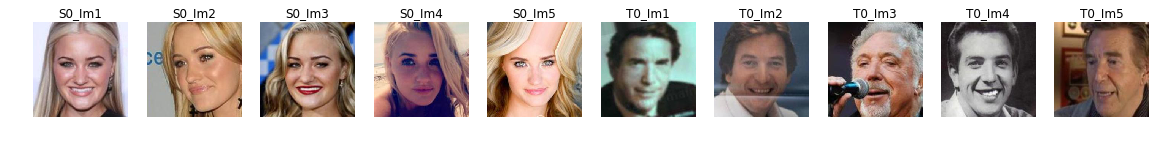

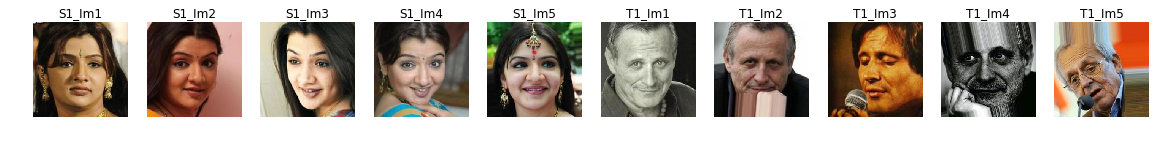

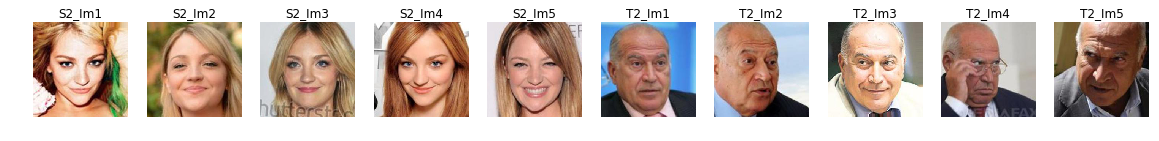

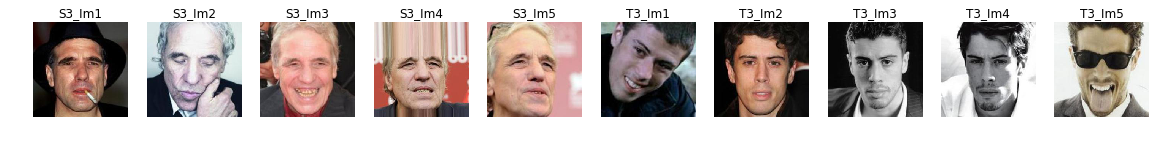

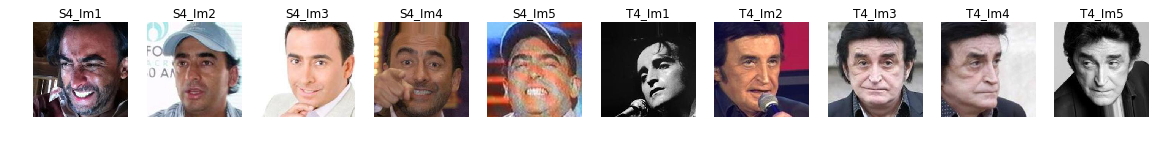

In [4]:
for idx in df.index[:5]:
    source_imgs = df.loc[idx].source_imgs
    target_imgs = df.loc[idx].target_imgs
    plt.figure(figsize=(20, 5))
    for i, img_name in enumerate(source_imgs.split('|'), 1):
        img = Image.open(os.path.join(imgs_path,img_name))
        plt.subplot(1, 10, i)
        plt.title('S{}_Im{}'.format(idx,i))
        plt.axis('off')
        plt.imshow(img)
        
    for i, img_name in enumerate(target_imgs.split('|'), 1):
        img = Image.open(os.path.join(imgs_path,img_name))
        plt.subplot(1, 10, i+5)
        plt.title('T{}_Im{}'.format(idx,i))
        plt.axis('off')
        plt.imshow(img)
    plt.show()

## Trying black box

In order to use black box, you should place BB file near your code or add it to your Path variable. Depending on your version of python and operating system download and store corresponding version of file. Here we use MCS2018.cpython-36m-x86_64-linux-gnu.so. Once you've done this, you should be able to import MCS2018 library:


In [5]:
import MCS2018

First of all, create an instance of black box. Note, that if you have GPU available, you can specify GPU card number. If you're using CPU only, write -1

In [6]:
gpu_id = 1
net = MCS2018.Predictor(gpu_id)

Now you can get face descriptor from a photo. But first you need to preprocess image accordingly

In [7]:
def preprocess_img(img):
    MEAN = [0.485, 0.456, 0.406]
    STD = [0.229, 0.224, 0.225]
    preprocessing = transforms.Compose([
                    transforms.CenterCrop(224),
                    transforms.Resize(112),
                    transforms.ToTensor(),
                    transforms.Normalize(mean=MEAN, std=STD),
                    ])
    img_arr = preprocessing(img).unsqueeze(0).numpy()
    return img_arr
img_arr = preprocess_img(img)
img_arr.shape

(1, 3, 112, 112)

In [8]:
img_descriptor = net.submit(img_arr).squeeze()
img_descriptor.shape

(512,)

Distance between descriptors of the same identity is small while distance between different persons is high:

In [9]:
source_imgs = df.loc[0].source_imgs
target_imgs = df.loc[0].target_imgs

In [10]:
%%time
source_desc=[]
target_desc=[]
for img_name in source_imgs.split('|'):
    img = Image.open(os.path.join(imgs_path,img_name))
    img_arr = preprocess_img(img)
    source_desc.append(net.submit(img_arr).squeeze())
    
for img_name in target_imgs.split('|'):
    img = Image.open(os.path.join(imgs_path,img_name))
    img_arr = preprocess_img(img)
    target_desc.append(net.submit(img_arr).squeeze())

CPU times: user 90.2 ms, sys: 61.8 ms, total: 152 ms
Wall time: 176 ms


In [11]:
dist = lambda x, y: np.round(np.sqrt(((x - y) ** 2).sum(axis=0)),4)


In [12]:
print('Dist between S0_Im0 and S0_Imi:',list(map(dist,5*[source_desc[0]],source_desc)))
print('Dist between S0_Im0 and T0_Imi:',list(map(dist,5*[source_desc[0]],target_desc)))

Dist between S0_Im0 and S0_Imi: [0.0, 0.8651, 0.5897, 0.9617, 0.8777]
Dist between S0_Im0 and T0_Imi: [1.2972, 1.3565, 1.351, 1.3601, 1.4243]


Your goal is to modify source images so that the distance between modified source and target is small.

## What is 'small'? SSIM metric

SSIM metric shows the similarity between 2 images. For same images, SSIM=1. For different images SSIM -> 0. In this challenge we consider SSIM distance after Image preprocessing, but before mean/std normalization:

In [13]:
def img_to_crop(img):
    preprocessing = transforms.Compose([
                    transforms.CenterCrop(224),
                    transforms.Resize(112),
                    ])
    return preprocessing(img)


def crop_to_tensor(img):
    MEAN = [0.485, 0.456, 0.406]
    STD = [0.229, 0.224, 0.225]
    preprocessing = transforms.Compose([
                    transforms.ToTensor(),
                    transforms.Normalize(mean=MEAN, std=STD),
                    ])
    img_arr = preprocessing(img).unsqueeze(0).numpy()
    return img_arr

In [14]:
from skimage.io import imsave, imread

In [15]:
img_name=source_imgs.split('|')[0]
img = Image.open(os.path.join(imgs_path,img_name))
img_crop = img_to_crop(img)

SSIM metric is sensitive even to small changes in the image. For example, let's see what happens if we change it by using jpg compression

In [16]:
img_crop.save('tmp.png')
img_crop.save('tmp.jpg')

In [17]:
img_crop_jpg=Image.open('tmp.jpg')
img_crop_png=Image.open('tmp.png')

In [18]:
ssim(np.array(img_crop_jpg), np.array(img_crop_png), multichannel=True)

0.9767639703461274

The distance is also affected:

In [19]:
des_jpg=net.submit(crop_to_tensor(img_crop_jpg)).squeeze(0)
des_png=net.submit(crop_to_tensor(img_crop_png)).squeeze(0)

dist(des_jpg,des_png)

0.2092

Since this challenge is about spoofing and not dealing with compression issues, you'll submit only png images. Now let's look at submission format in more details:

## Sample submission

Your submission file should consist of 5000 source png images as well as npy matrix with precalculated descriptors. This sounds strange but this is made to reduce load of evaluation server and to allow results appear quicker on leaderboard.

Let's make a submission with unchanged images as an example. First of all, you need to save png source images. Note that you submit 112x112 crops. 

In [237]:
os.mkdir('sumbit_01')

In [23]:
source_imgs_list = pd.read_csv('data/submit_list.csv')

In [25]:
for img_path in source_imgs_list.path:
    img = Image.open(os.path.join(imgs_path,img_path[:-3]+'jpg'))
    img_crop = img_to_crop(img)
    img_crop.save(os.path.join('submit_01',img_path))

This is sample submission and we do not change images. When you submit modified images, stick to this file names example. However, keep in mind that SSIM between modified images and original ones should not be less than 0.95 or your sumbission will fail.

Now let's precompute descriptors for submission:

In [26]:
descriptors = np.ones((5000, 512), dtype=np.float32)
for idx, img_path in tqdm(enumerate(source_imgs_list.path.values), total=len(source_imgs_list.path.values)):
    img = Image.open(os.path.join('submit_01', img_path))
    img_arr = crop_to_tensor(img)
    img_des = net.submit(img_arr).squeeze()
    descriptors[idx] = img_des

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

In [27]:
descriptors_path = 'submit_01/descriptors.npy'
np.save(descriptors_path, descriptors)

In [28]:

source_imgs_list_png = source_imgs_list.copy()
source_imgs_list_png.path = source_imgs_list_png.path.apply(lambda x: x[:-3]+'png')


if not os.path.isdir('./submits/'):
    os.makedirs('./submits')
submit_file = './submits/submit_01.zip'
    
with zipfile.ZipFile(submit_file,'w') as myzip:
    for img_name in tqdm(source_imgs_list_png.path.values,
                         desc='archive'):
        myzip.write(os.path.join('submit_01', img_name), arcname=img_name)
    myzip.write(descriptors_path, arcname='descriptors.npy')

HBox(children=(IntProgress(value=0, description='archive', max=5000), HTML(value='')))

Now you can submit created file to codalab server. Note that we'll run evaluation on submitted images sometimes to check that  descriptors match images. Participants who will submit different descriptors and images will be banned.